# **Household hourly energy demand forecast**

### 0. Imports 

In [1]:
# Core
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

### 1. Upload data & Parsing

In [2]:
# Read the data
df = pd.read_csv("household_power_consumption.csv", sep=";", low_memory=False)


In [3]:
# Dataset info
print(df.info())

df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB
None


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [4]:
df.tail()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
2075254,26/11/2010,20:58:00,0.946,0.000,240.430,4.000,0.000,0.000,0.0
2075255,26/11/2010,20:59:00,0.944,0.000,240.000,4.000,0.000,0.000,0.0
2075256,26/11/2010,21:00:00,0.938,0.000,239.820,3.800,0.000,0.000,0.0
2075257,26/11/2010,21:01:00,0.934,0.000,239.700,3.800,0.000,0.000,0.0
2075258,26/11/2010,21:02:00,0.932,0.000,239.550,3.800,0.000,0.000,0.0


In [5]:
# parsing --> date + time

df["Datetime"] = pd.to_datetime(
    df["Date"] + " " + df["Time"],
    format="%d/%m/%Y %H:%M:%S"
)

# set time index
df = df.set_index("Datetime")
df = df.sort_index()

# Convert the numeric columns into floats
numeric_cols = df.columns.difference(["Date", "Time"])

df[numeric_cols] = df[numeric_cols].apply(
    pd.to_numeric, errors="coerce"
)

# check
print(df.info())
df.tail()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    float64
 3   Global_reactive_power  float64
 4   Voltage                float64
 5   Global_intensity       float64
 6   Sub_metering_1         float64
 7   Sub_metering_2         float64
 8   Sub_metering_3         float64
dtypes: float64(7), object(2)
memory usage: 158.3+ MB
None


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,,,
2010-11-26 20:58:00,26/11/2010,20:58:00,0.946,0.0,240.43,4.0,0.0,0.0,0.0
2010-11-26 20:59:00,26/11/2010,20:59:00,0.944,0.0,240.00,4.0,0.0,0.0,0.0
2010-11-26 21:00:00,26/11/2010,21:00:00,0.938,0.0,239.82,3.8,0.0,0.0,0.0
2010-11-26 21:01:00,26/11/2010,21:01:00,0.934,0.0,239.70,3.8,0.0,0.0,0.0
2010-11-26 21:02:00,26/11/2010,21:02:00,0.932,0.0,239.55,3.8,0.0,0.0,0.0


### 2. Missing data handling

Date                         0
Time                         0
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64


<Axes: xlabel='Datetime'>

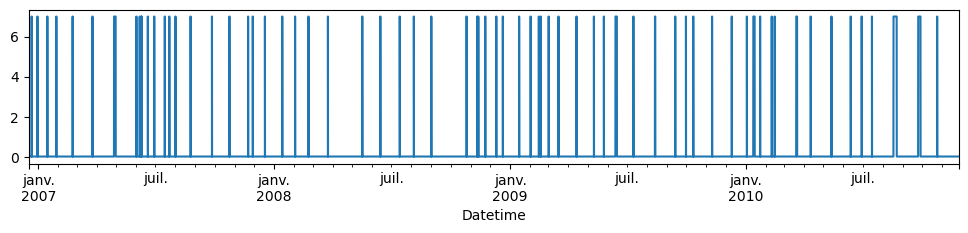

In [6]:
# check missing data
print(df.isnull().sum())

# plot missing data distribution
(df.isna().sum(axis=1)
 .plot(figsize=(12, 2)))

In [7]:
# 1. Identify rows with at least one NaN
nan_mask = df.isna().any(axis=1)

# 2. Find consecutive blocks
# creates a group each time we change state (NaN -> not NaN or viceversa)
groups = (nan_mask != nan_mask.shift()).cumsum()

# 3. Counts the length of each block of NaN
nan_block_lengths = nan_mask.groupby(groups).sum()

# 4. Max, min, mean, median
max_nan_run = nan_block_lengths.max()
mean_nan_run = nan_block_lengths.mean()
median_nan_run = nan_block_lengths.median()

# 5. Beginning date and ending date of the longest block
longest_block = nan_mask.groupby(groups).apply(lambda x: x.index if x.sum() == max_nan_run else None).dropna().iloc[0]

print(f"Longest consecutive NaN period: {max_nan_run} rows")
print(f"From {longest_block[0]} to {longest_block[-1]}")
print(f"\nAverage consecutive NaN rows: {mean_nan_run:.2f}")
print(f"Median consecutive NaN rows: {median_nan_run}")


Longest consecutive NaN period: 7226 rows
From 2010-08-17 21:02:00 to 2010-08-22 21:27:00

Average consecutive NaN rows: 181.67
Median consecutive NaN rows: 0.0


In [8]:
# time interpolation

df['was_interpolated'] = nan_mask

df = df.interpolate(method="time")
print(df.isna().sum())

# Numero totale di righe che contenevano NaN
num_interpolated = df['was_interpolated'].sum()
print(f"Number of rows that were interpolated: {num_interpolated}")

df.info()
df.head()


C:\Users\imhii\AppData\Local\Temp\ipykernel_23200\3851704155.py:5: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.interpolate(method="time")


Date                     0
Time                     0
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
was_interpolated         0
dtype: int64
Number of rows that were interpolated: 25979
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 10 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    float64
 3   Global_reactive_power  float64
 4   Voltage                float64
 5   Global_intensity       float64
 6   Sub_metering_1         float64
 7   Sub_metering_2         float64
 8   Sub_metering_3         float64
 9   was_interpolated       bool   
dtypes: bool(1), float64(7), object(2)
memory usage: 160.3+ MB


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,was_interpolated
Datetime,,,,,,,,,,
2006-12-16 17:24:00,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,False
2006-12-16 17:25:00,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,False
2006-12-16 17:26:00,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,False
2006-12-16 17:27:00,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,False
2006-12-16 17:28:00,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,False


Missing values account for approximately 1.25% of the dataset and affect all measurement variables simultaneously.

Missing observations are distributed over time, mostly as isolated points or short consecutive intervals, with the longest consecutive missing period spanning 7,226 rows (from 2010-08-17 21:02:00 to 2010-08-22 21:27:00). The average length of missing blocks is 181.67 rows, and the median is 0 rows, indicating that most missing values are isolated.

Given the regular time index and the limited extent of missingness, time-based linear interpolation was applied to obtain a complete time series. Additionally, a boolean flag column `was_interpolated` was added to indicate which rows originally contained missing values.


### 3. Feature engineering


Formula used for conversion:

    `Energy (Wh)= Power (kW)×60/1000​ per min`

In [9]:
# 1) Conversion Power (kW per min) → Energy (Wh per min)
# Global_active_power & Global_reactive_power in kW → Wh per min
df['Global_active_energy'] = df['Global_active_power'] * 1000 / 60
df['Global_reactive_energy'] = df['Global_reactive_power'] * 1000 / 60

# 2) Remaining_submetering
df['Remaining_submetering'] = df['Global_active_energy'] - (
    df['Sub_metering_1'] + df['Sub_metering_2'] + df['Sub_metering_3']
)

# 3) Other temporal features 
df['Hour'] = df.index.hour
df['DayOfWeek'] = df.index.dayofweek   # 0=Monday, 6=Sunday
df['Weekend'] = df['DayOfWeek'].isin([5,6]).astype(int)

# Season 
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

df['Season'] = df.index.month.map(get_season)

# Reorganise columns
order = [
    "Date",
    "Time",
    "Hour",
    "DayOfWeek",
    "Weekend",
    "Season",
    "Global_active_power",
    "Global_active_energy",
    "Global_reactive_power",
    "Global_reactive_energy",
    "Voltage",
    "Global_intensity",
    "Sub_metering_1",
    "Sub_metering_2",
    "Sub_metering_3",
    "Remaining_submetering",
    "was_interpolated"
]


df = df[order]


# check
print(df.info())
df.head()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   Date                    object 
 1   Time                    object 
 2   Hour                    int32  
 3   DayOfWeek               int32  
 4   Weekend                 int32  
 5   Season                  object 
 6   Global_active_power     float64
 7   Global_active_energy    float64
 8   Global_reactive_power   float64
 9   Global_reactive_energy  float64
 10  Voltage                 float64
 11  Global_intensity        float64
 12  Sub_metering_1          float64
 13  Sub_metering_2          float64
 14  Sub_metering_3          float64
 15  Remaining_submetering   float64
 16  was_interpolated        bool   
dtypes: bool(1), float64(10), int32(3), object(3)
memory usage: 247.4+ MB
None


,Date,Time,Hour,DayOfWeek,Weekend,Season,Global_active_power,Global_active_energy,Global_reactive_power,Global_reactive_energy,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Remaining_submetering,was_interpolated
Datetime,,,,,,,,,,,,,,,,,
2006-12-16 17:24:00,16/12/2006,17:24:00,17,5,1,Winter,4.216,70.266667,0.418,6.966667,234.84,18.4,0.0,1.0,17.0,52.266667,False
2006-12-16 17:25:00,16/12/2006,17:25:00,17,5,1,Winter,5.360,89.333333,0.436,7.266667,233.63,23.0,0.0,1.0,16.0,72.333333,False
2006-12-16 17:26:00,16/12/2006,17:26:00,17,5,1,Winter,5.374,89.566667,0.498,8.300000,233.29,23.0,0.0,2.0,17.0,70.566667,False
2006-12-16 17:27:00,16/12/2006,17:27:00,17,5,1,Winter,5.388,89.800000,0.502,8.366667,233.74,23.0,0.0,1.0,17.0,71.800000,False
2006-12-16 17:28:00,16/12/2006,17:28:00,17,5,1,Winter,3.666,61.100000,0.528,8.800000,235.68,15.8,0.0,1.0,17.0,43.100000,False


In [10]:
# Save by-minute version 
df_byminute = df.copy()

# Hourly aggregation
df = df.resample("H").agg({
    # Energy variables (sum)
    'Global_active_energy': 'sum',
    'Global_reactive_energy': 'sum',
    'Sub_metering_1': 'sum',
    'Sub_metering_2': 'sum',
    'Sub_metering_3': 'sum',
    'Remaining_submetering': 'sum',

    # Physical averages
    'Voltage': 'mean',
    'Global_intensity': 'mean',

    # Temporal / categorical
    'Date': 'first',
    'Time': 'first',
    'Hour': 'first',
    'DayOfWeek': 'first',
    'Weekend': 'first',
    'Season': 'first',

    # Data quality flag
    'was_interpolated': 'any'
})


# Conversion Wh → kWh for standard interpretation
energy_cols = [
    "Global_active_energy",
    "Global_reactive_energy",
    "Sub_metering_1",
    "Sub_metering_2",
    "Sub_metering_3",
    "Remaining_submetering"
]

for col in energy_cols:
    df[col + "_kWh"] = df[col] / 1000

# Renaming sub-metering for clarity
df = df.rename(columns={
    "Sub_metering_1_kWh": "kitchen_energy_kwh",
    "Sub_metering_2_kWh": "laundry_energy_kwh",
    "Sub_metering_3_kWh": "climate_energy_kwh",
    "Remaining_submetering_kWh": "other_energy_kwh",
    "Global_active_energy_kWh": "active_energy_kwh",
    "Global_reactive_energy_kWh": "reactive_energy_kwh"
})

# Reorganise columns
order = [
    "Date",
    "Time",
    "Hour",
    "DayOfWeek",
    "Weekend",
    "Season",
    "active_energy_kwh",
    "reactive_energy_kwh",
    "Voltage",
    "Global_intensity",
    "kitchen_energy_kwh",
    "laundry_energy_kwh",
    "climate_energy_kwh",
    "other_energy_kwh",
    "was_interpolated"
]


df = df[order]

# Columns names in lowercase
df.columns = [col.lower() for col in df.columns]

# check
print(df.info())
df.head()

C:\Users\imhii\AppData\Local\Temp\ipykernel_23200\4103437217.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.resample("H").agg({


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 34589 entries, 2006-12-16 17:00:00 to 2010-11-26 21:00:00
Freq: h
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   date                 34589 non-null  object 
 1   time                 34589 non-null  object 
 2   hour                 34589 non-null  int32  
 3   dayofweek            34589 non-null  int32  
 4   weekend              34589 non-null  int32  
 5   season               34589 non-null  object 
 6   active_energy_kwh    34589 non-null  float64
 7   reactive_energy_kwh  34589 non-null  float64
 8   voltage              34589 non-null  float64
 9   global_intensity     34589 non-null  float64
 10  kitchen_energy_kwh   34589 non-null  float64
 11  laundry_energy_kwh   34589 non-null  float64
 12  climate_energy_kwh   34589 non-null  float64
 13  other_energy_kwh     34589 non-null  float64
 14  was_interpolated     34589 non-null  bool  

,date,time,hour,dayofweek,weekend,season,active_energy_kwh,reactive_energy_kwh,voltage,global_intensity,kitchen_energy_kwh,laundry_energy_kwh,climate_energy_kwh,other_energy_kwh,was_interpolated
Datetime,,,,,,,,,,,,,,,
2006-12-16 17:00:00,16/12/2006,17:24:00,17,5,1,Winter,2.533733,0.137400,234.643889,18.100000,0.0,0.019,0.607,1.907733,False
2006-12-16 18:00:00,16/12/2006,18:00:00,18,5,1,Winter,3.632200,0.080033,234.580167,15.600000,0.0,0.403,1.012,2.217200,False
2006-12-16 19:00:00,16/12/2006,19:00:00,19,5,1,Winter,3.400233,0.085233,233.232500,14.503333,0.0,0.086,1.001,2.313233,False
2006-12-16 20:00:00,16/12/2006,20:00:00,20,5,1,Winter,3.268567,0.075100,234.071500,13.916667,0.0,0.000,1.007,2.261567,False
2006-12-16 21:00:00,16/12/2006,21:00:00,21,5,1,Winter,3.056467,0.076667,237.158667,13.046667,0.0,0.025,1.033,1.998467,False


### 4. Exploratory Data Analysis

In [11]:
# descriptive statistics
num_var = df[['active_energy_kwh', 'reactive_energy_kwh', 'voltage', 
              'global_intensity', 'kitchen_energy_kwh', 'laundry_energy_kwh',
              'climate_energy_kwh', 'other_energy_kwh']]

num_var.describe()

,active_energy_kwh,reactive_energy_kwh,voltage,global_intensity,kitchen_energy_kwh,laundry_energy_kwh,climate_energy_kwh,other_energy_kwh
count,34589.000000,34589.000000,34589.000000,34589.000000,34589.000000,34589.000000,34589.000000,34589.000000
mean,1.090237,0.123644,240.832682,4.621615,0.066566,0.077351,0.386528,0.559792
std,0.894216,0.067069,3.001576,3.743583,0.211103,0.250098,0.440442,0.494604
min,0.046733,0.000000,225.834500,0.503333,0.000000,0.000000,0.000000,0.046733
25%,0.342867,0.077933,239.178167,1.516667,0.000000,0.000000,0.039000,0.261833
50%,0.803216,0.107133,240.974667,3.423333,0.000000,0.020000,0.099000,0.348000
75%,1.578700,0.149500,242.689000,6.603333,0.000000,0.039000,0.845000,0.669500
max,6.560533,0.774333,251.902000,28.383333,2.902000,2.786000,1.471470,3.890233


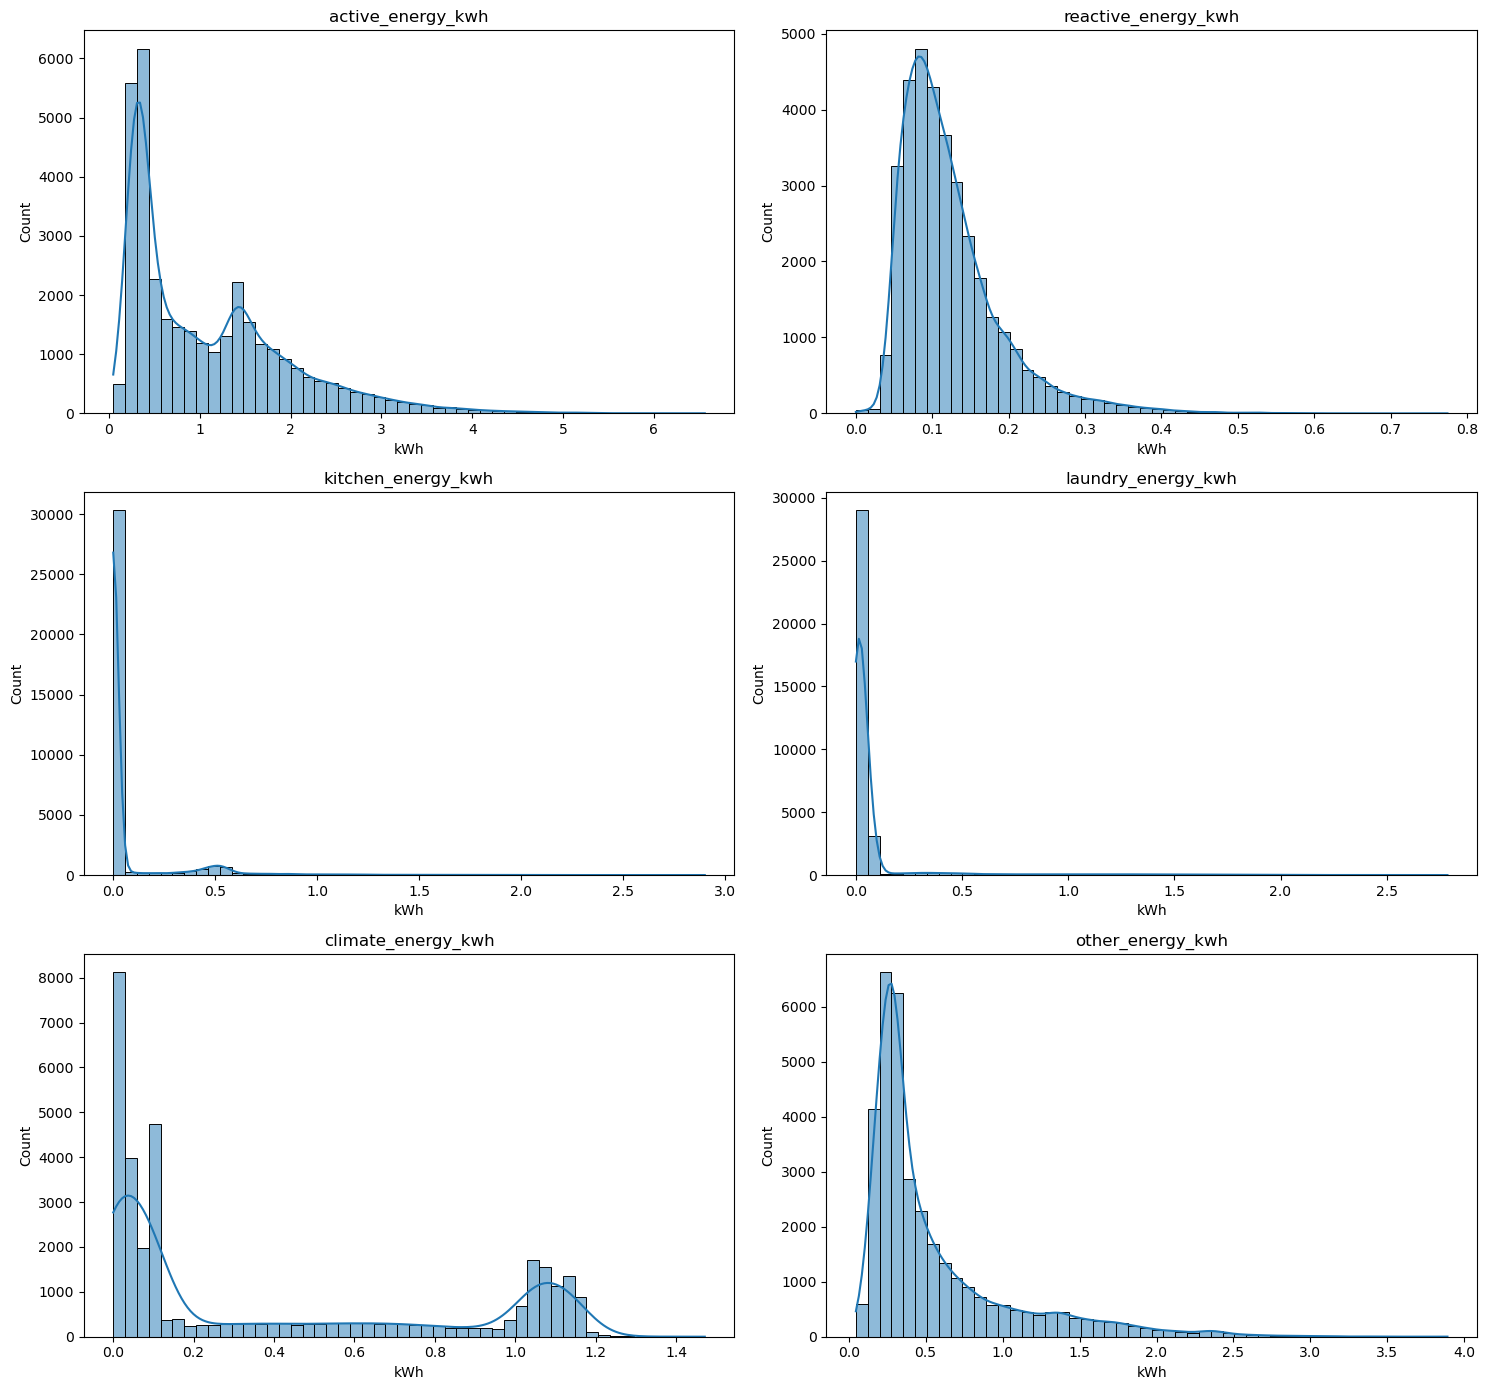

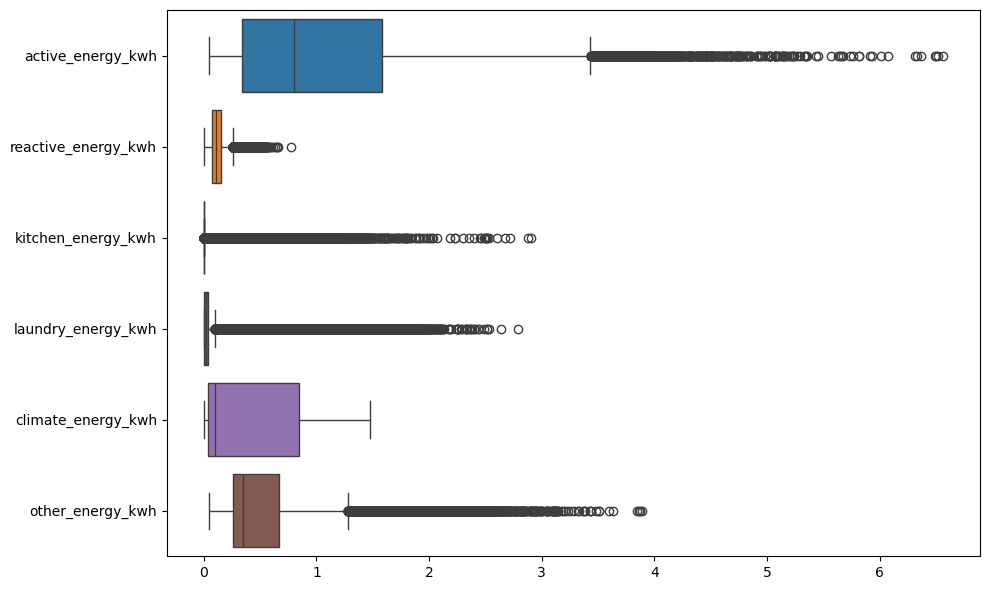

In [12]:
# distribution of energy measurements 
energy_cols = [
    "active_energy_kwh", "reactive_energy_kwh",
    "kitchen_energy_kwh", "laundry_energy_kwh",
    "climate_energy_kwh", "other_energy_kwh"
]

fig, axes = plt.subplots(3, 2, figsize=(15, 14))
axes = axes.flatten()

for i, col in enumerate(energy_cols):
    sns.histplot(
        df[col],
        bins=50,
        kde=True,
        ax=axes[i]
    )
    axes[i].set_title(col)
    axes[i].set_xlabel("kWh")

plt.tight_layout()
plt.show()

# boxplots of energy variables
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df[energy_cols],
    orient="h"
)
plt.tight_layout()
plt.show()


The distribution of all energy-related variables is strongly right-skewed and clearly deviates from normality.
Most observations are concentrated at low consumption levels, while a limited number of hours exhibit very high energy usage, resulting in long right tails.

Several sub-metering variables are zero-inflated, reflecting the intermittent usage of specific appliances (e.g., kitchen, laundry, climate systems), which are inactive during most hours and produce consumption spikes only when in use.

Voltage, in contrast, shows limited variability and a stable distribution over time.

The presence of extreme values is consistent with genuine high-consumption events rather than data errors.

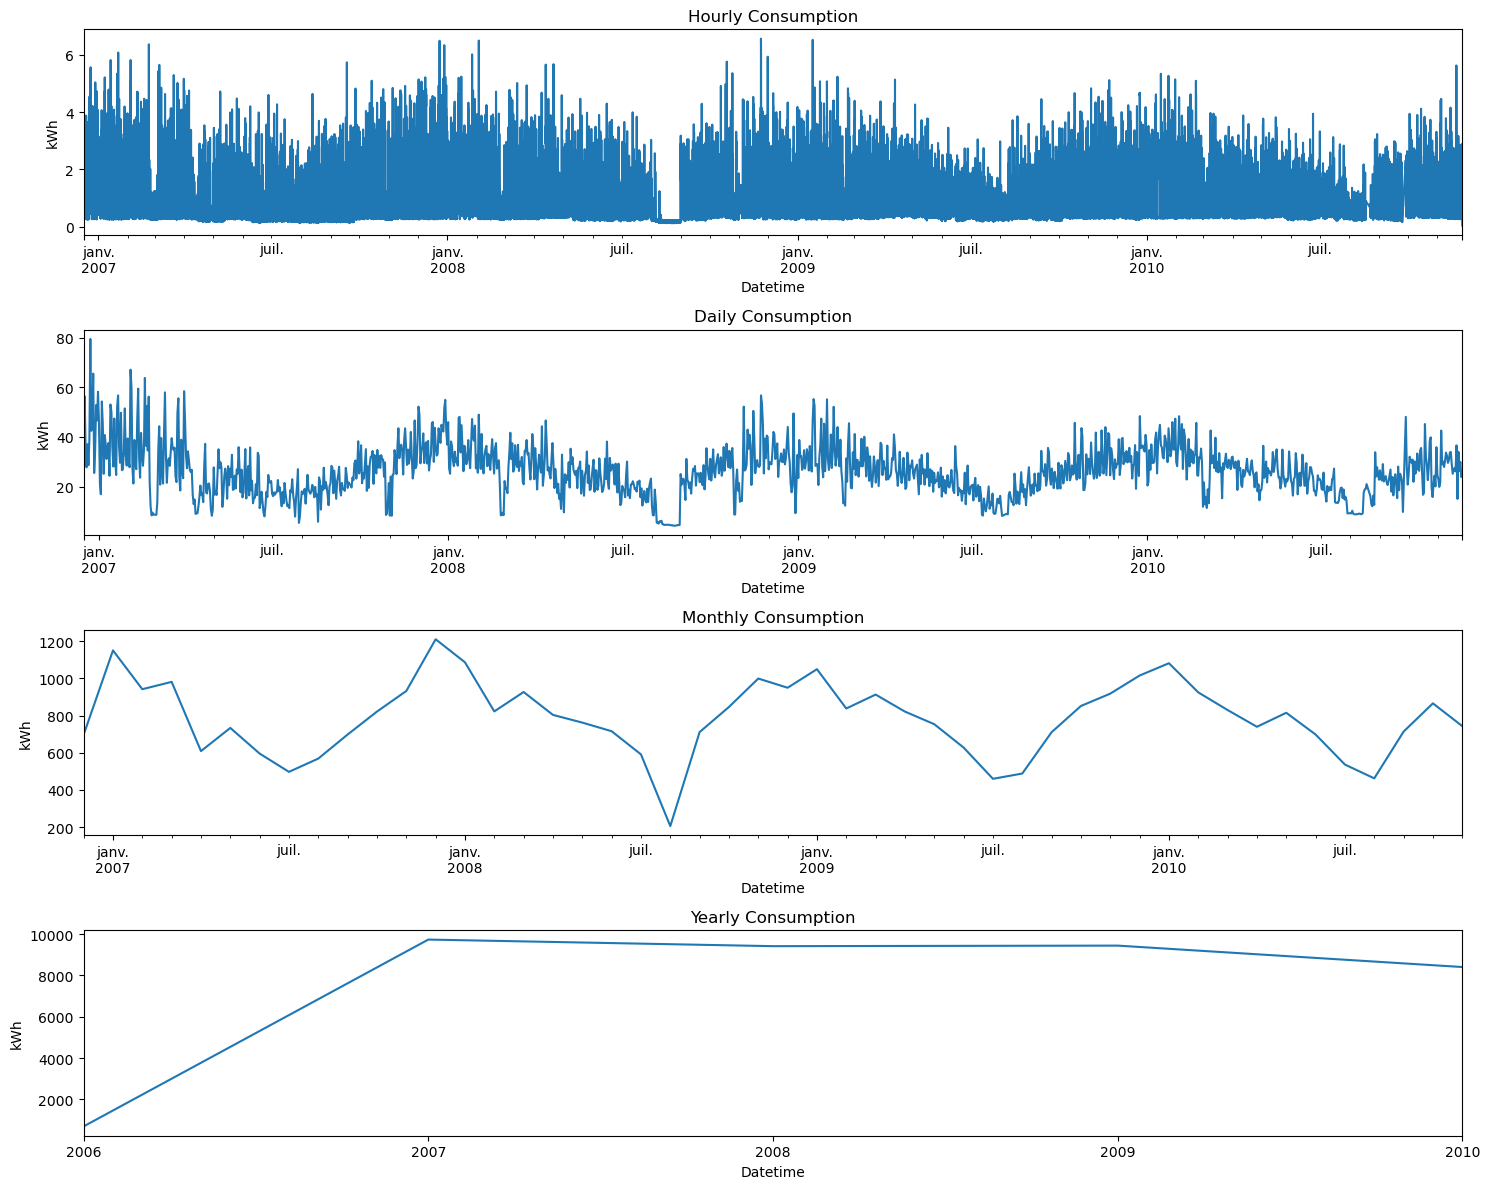

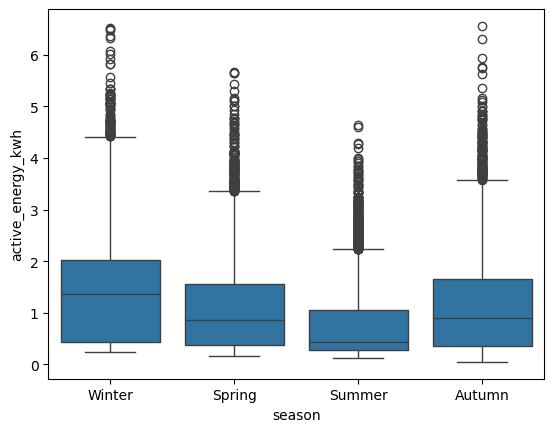

In [13]:
# Active energy consumption over time

# create datasets for ploting
df_daily = df['active_energy_kwh'].resample("D").sum()  # daily
df_monthly = df['active_energy_kwh'].resample("ME").sum() # monthly
df_yearly = df['active_energy_kwh'].resample("YE").sum()   # yearly

# plots
fig, axes = plt.subplots(4, 1, figsize=(15,12), sharex=False)

df['active_energy_kwh'].plot(ax=axes[0], title="Hourly Consumption")
df_daily.plot(ax=axes[1], title="Daily Consumption")
df_monthly.plot(ax=axes[2], title="Monthly Consumption")
df_yearly.plot(ax=axes[3], title="Yearly Consumption")

for ax in axes:
    ax.set_ylabel("kWh")

plt.tight_layout()
plt.show()


# boxplot seasonality
sns.boxplot(x='season', y='active_energy_kwh', data=df)
plt.show()




The plots show high hourly and daily variability in active energy consumption, reflecting short-term fluctuations in household electricity usage. 

At the monthly aggregation level a clear seasonal pattern can be seen, with higher energy consumption during the winter months and lower consumption in summer. This pattern is also confirmed by the distribution in the boxplot above.  

On a yearly basis, total energy consumption seems to be relatively stable across the observation period. The apparent increase from 2006 and 2007 is not representative of real increase in consumption as data for 2006 only include the last 14 days of the year.

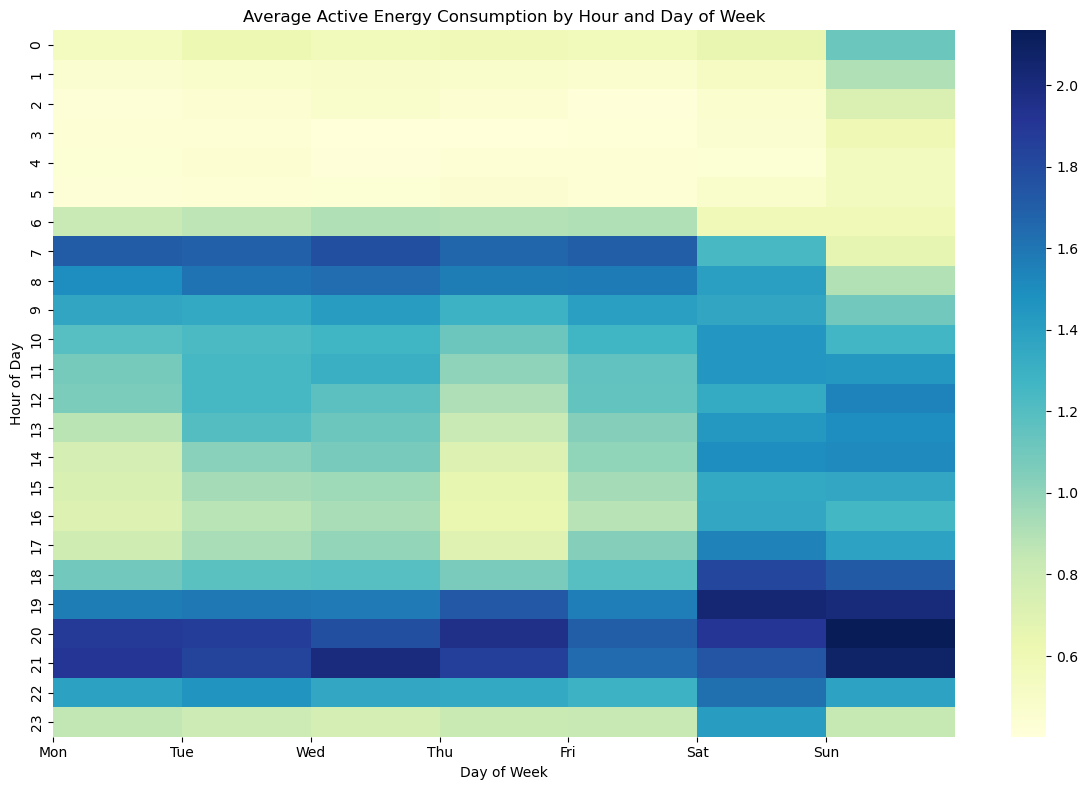

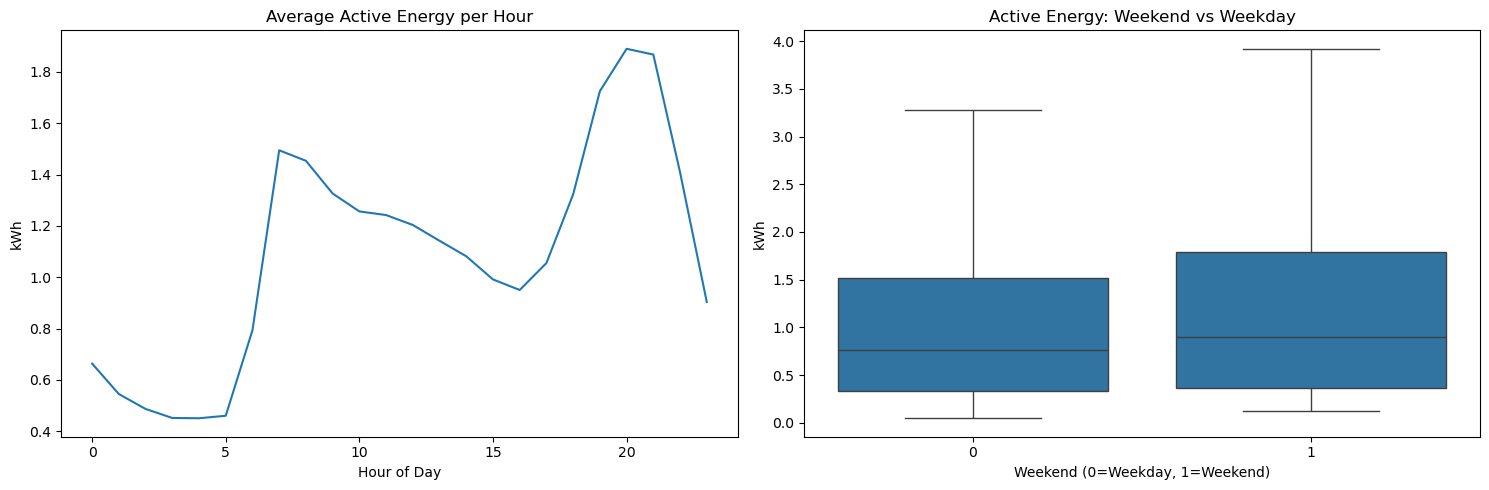

In [14]:
# Heatmap: hour vs day of week
plt.figure(figsize=(12, 8))

pivot = df.pivot_table(
    index='hour',
    columns='dayofweek',
    values='active_energy_kwh',
    aggfunc='mean'
)

sns.heatmap(
    pivot,
    cmap="YlGnBu"
)

plt.title("Average Active Energy Consumption by Hour and Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Hour of Day")
plt.xticks(
    ticks=range(7),
    labels=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
)

plt.tight_layout()
plt.show()



fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Average hourly profile
df.groupby('hour')['active_energy_kwh'].mean().plot(
    ax=axes[0]
)
axes[0].set_title("Average Active Energy per Hour")
axes[0].set_xlabel("Hour of Day")
axes[0].set_ylabel("kWh")

# Weekend vs Weekday boxplot
sns.boxplot(
    x='weekend',
    y='active_energy_kwh',
    data=df,
    showfliers=False,
    ax=axes[1]
)
axes[1].set_title("Active Energy: Weekend vs Weekday")
axes[1].set_xlabel("Weekend (0=Weekday, 1=Weekend)")
axes[1].set_ylabel("kWh")

plt.tight_layout()
plt.show()




The heatmap reveals differences in electricity consumption behavior between weekends and working days.

Across all days of the week, consistently low average consumption levels are observed during nighttime hours, corresponding to typical sleeping schedules. Notable differences emerge in the early morning (~ 6–8 a.m.), where energy consumption is higher on weekdays, likely reflecting school and work-related activities.

During weekends, energy consumption appears more evenly distributed throughout the day, whereas on weekdays relatively lower consumption levels are observed during early afternoon hours (approximately 13–17). Peak consumption is concentrated in the evening hours (19–21), with the highest levels observed on Sundays. These patterns are further confirmed by the average hourly consumption profile shown in the line plot.

The boxplot comparison highlights a slightly higher median energy consumption on weekends compared to working days, as well as increased variability.
 

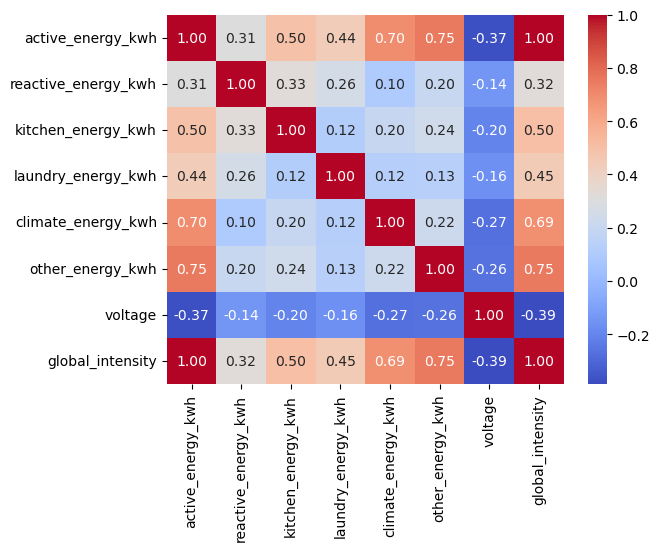

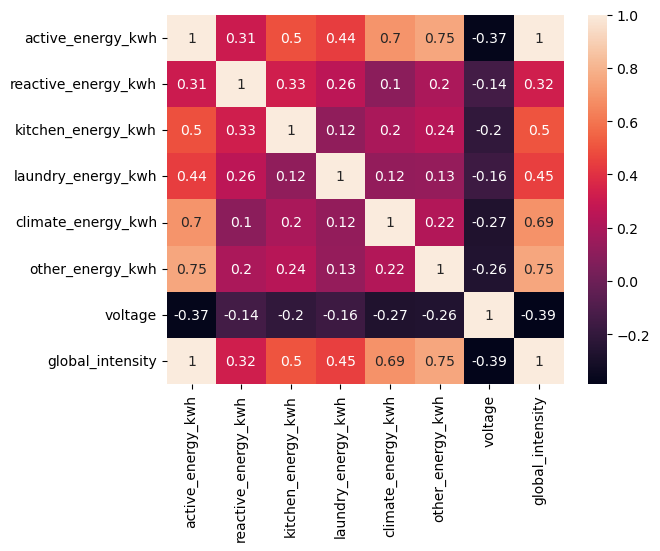

In [15]:
# correlation heatmap

energy_cols_corr = [
    'active_energy_kwh',
    'reactive_energy_kwh',
    'kitchen_energy_kwh',
    'laundry_energy_kwh',
    'climate_energy_kwh',
    'other_energy_kwh'
]

sns.heatmap(
    df[energy_cols_corr + ['voltage', 'global_intensity']].corr(),
    annot=True,
    fmt=".2f",
    cmap="coolwarm"
)
plt.show()

sns.heatmap(df[energy_cols + ['voltage','global_intensity']].corr(), annot=True)
plt.show()


The correlation heatmap highlights several meaningful relationships among the variables.

- Voltage exhibits moderate negative correlations with all energy-related variables. This behavior is expected, as higher voltage levels typically correspond to lower current intensity for a given power demand, resulting in an inverse relationship with energy consumption.

- Global intensity and total active energy are perfectly positively correlated (corr = 1). The two variables represent the same underlying physical quantity expressed through closely related measurements, giving redundant information. 

- All energy consumption components expressed in kWh are positively correlated with each other. In particular, climate energy consumption (corr = 0.69) and other energy consumption (corr = 0.75) show strong correlations with the target variable active energy. This suggests that these components represent a substantial share of total household energy usage and are key drivers of overall consumption.

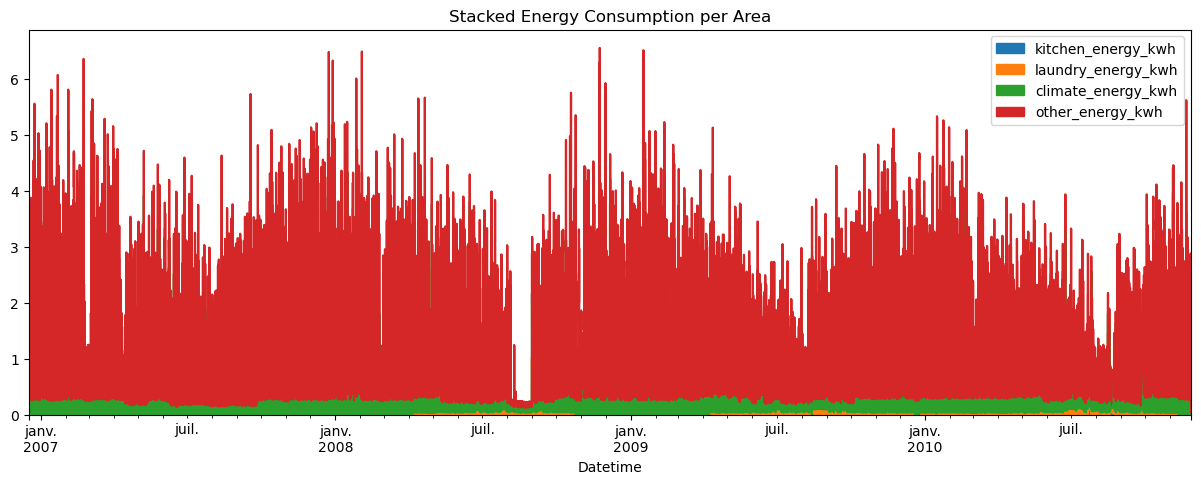

In [41]:
# stacked energy consumption plot
df[['kitchen_energy_kwh','laundry_energy_kwh','climate_energy_kwh','other_energy_kwh']].plot.area(figsize=(15,5))
plt.title("Stacked Energy Consumption per Area")
plt.show()


The stacked area plot illustrates the contribution of different household areas to total energy consumption over time. Kitchen and laundry appliances account for only a small fraction of overall energy usage, reflecting their intermittent and short-duration operation.

Climate-related consumption represents a larger share compared to kitchen and laundry, likely due to the use of energy-intensive appliances such as electric water heaters and air conditioning.

However, the largest contribution to total energy consumption originates from the remaining household areas, which include appliances and electrical loads not explicitly captured by the sub-metering variables. This component consistently dominates overall energy usage and plays a key role in determining total demand of energy.

### 5. Feature selection, temporal encoding & dataset splitting

To prepare the dataset for modeling, in this section we will: 

- encode temporal features (hour of day and day of week) as cycles using sine and cosine transformations. 

- remove raw calendar variables such as date, time, hour, and day of week, as they become redundant. Additionally, global_intensity will be excluded due to perfect correlation with the target variable, to prevent information leakage.

- split the dataset into train/test/val for machine learning models and train/test for time series models. To ensure fair comparison between classical time series models (SARIMA/ETS) and machine learning models (LSTM, XGBoost), the test set is kept identical for all approaches. 
All splits respect the temporal order of the data.


In [42]:
df_eda = df.copy()   # dataset used for EDA

# cyclic encoding
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

df['dow_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
df['dow_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)

# one-hot encoding
df = pd.get_dummies(df, columns=['season'], drop_first=True)

# remove variables
df = df.drop(columns=[
    'date',
    'time',
    'hour',
    'dayofweek',
    'global_intensity'
])

# check
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 34589 entries, 2006-12-16 17:00:00 to 2010-11-26 21:00:00
Freq: h
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   weekend              34589 non-null  int32  
 1   active_energy_kwh    34589 non-null  float64
 2   reactive_energy_kwh  34589 non-null  float64
 3   voltage              34589 non-null  float64
 4   kitchen_energy_kwh   34589 non-null  float64
 5   laundry_energy_kwh   34589 non-null  float64
 6   climate_energy_kwh   34589 non-null  float64
 7   other_energy_kwh     34589 non-null  float64
 8   was_interpolated     34589 non-null  bool   
 9   hour_sin             34589 non-null  float64
 10  hour_cos             34589 non-null  float64
 11  dow_sin              34589 non-null  float64
 12  dow_cos              34589 non-null  float64
 13  season_Spring        34589 non-null  bool   
 14  season_Summer        34589 non-null  bool  

,weekend,active_energy_kwh,reactive_energy_kwh,voltage,kitchen_energy_kwh,laundry_energy_kwh,climate_energy_kwh,other_energy_kwh,was_interpolated,hour_sin,hour_cos,dow_sin,dow_cos,season_Spring,season_Summer,season_Winter
Datetime,,,,,,,,,,,,,,,,
2006-12-16 17:00:00,1,2.533733,0.137400,234.643889,0.0,0.019,0.607,1.907733,False,-0.965926,-2.588190e-01,-0.974928,-0.222521,False,False,True
2006-12-16 18:00:00,1,3.632200,0.080033,234.580167,0.0,0.403,1.012,2.217200,False,-1.000000,-1.836970e-16,-0.974928,-0.222521,False,False,True
2006-12-16 19:00:00,1,3.400233,0.085233,233.232500,0.0,0.086,1.001,2.313233,False,-0.965926,2.588190e-01,-0.974928,-0.222521,False,False,True
2006-12-16 20:00:00,1,3.268567,0.075100,234.071500,0.0,0.000,1.007,2.261567,False,-0.866025,5.000000e-01,-0.974928,-0.222521,False,False,True
2006-12-16 21:00:00,1,3.056467,0.076667,237.158667,0.0,0.025,1.033,1.998467,False,-0.707107,7.071068e-01,-0.974928,-0.222521,False,False,True


In [43]:
# splitting (70/15/15)

# common test set (last 15%)
n = len(df)
test_size = int(n * 0.15)  
test = df.iloc[-test_size:] 

# train/val for ML 
train_val = df.iloc[:-test_size]  
ratio_train_val = 70 / 85  # ≈ 0.8235
train_size = int(len(train_val) * ratio_train_val)
train = train_val.iloc[:train_size]
val   = train_val.iloc[train_size:]

# train for SARIMA and ETS
train_sarima = train_val['active_energy_kwh']
test_sarima  = df.iloc[-test_size:]['active_energy_kwh']

print("ML/DL splits:")
print(f"Train: {train.index.min()} -> {train.index.max()} ({len(train)} rows)")
print(f"Validation: {val.index.min()} -> {val.index.max()} ({len(val)} rows)")
print(f"Test: {test.index.min()} -> {test.index.max()} ({len(test)} rows)")
print("-"*60)
print("\nSARIMA/ETS splits:")
print(f"Train: {train_sarima.index.min()} -> {train_sarima.index.max()} ({len(train_sarima)} rows)")
print(f"Test: {test_sarima.index.min()} -> {test_sarima.index.max()} ({len(test_sarima)} rows)")



ML/DL splits:
Train: 2006-12-16 17:00:00 -> 2009-09-20 12:00:00 (24212 rows)
Validation: 2009-09-20 13:00:00 -> 2010-04-24 17:00:00 (5189 rows)
Test: 2010-04-24 18:00:00 -> 2010-11-26 21:00:00 (5188 rows)
------------------------------------------------------------

SARIMA/ETS splits:
Train: 2006-12-16 17:00:00 -> 2010-04-24 17:00:00 (29401 rows)
Test: 2010-04-24 18:00:00 -> 2010-11-26 21:00:00 (5188 rows)


### 6. Naive baseline

As a baseline model we use the consumption of the previous year exactly in the same period as the test test: 

- Test: 2010-04-24 18:00:00 -> 2010-11-26 21:00:00

- Baseline: 2009-04-24 18:00:00 -> 2009-11-26 21:00:00

We calculate the error metrics for this Naive model as a baseline to evaluate more sophisticated models. 

In [21]:
print(df.index)
print(df.index.dtype)
print(df.columns)

DatetimeIndex(['2006-12-16 17:00:00', '2006-12-16 18:00:00',
               '2006-12-16 19:00:00', '2006-12-16 20:00:00',
               '2006-12-16 21:00:00', '2006-12-16 22:00:00',
               '2006-12-16 23:00:00', '2006-12-17 00:00:00',
               '2006-12-17 01:00:00', '2006-12-17 02:00:00',
               ...
               '2010-11-26 12:00:00', '2010-11-26 13:00:00',
               '2010-11-26 14:00:00', '2010-11-26 15:00:00',
               '2010-11-26 16:00:00', '2010-11-26 17:00:00',
               '2010-11-26 18:00:00', '2010-11-26 19:00:00',
               '2010-11-26 20:00:00', '2010-11-26 21:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=34589, freq='h')
datetime64[ns]
Index(['weekend', 'active_energy_kwh', 'reactive_energy_kwh', 'voltage',
       'kitchen_energy_kwh', 'laundry_energy_kwh', 'climate_energy_kwh',
       'other_energy_kwh', 'was_interpolated', 'hour_sin', 'hour_cos',
       'dow_sin', 'dow_cos', 'season_Spring', 'season_Summe

In [44]:
# naive baseline using previous year same period
baseline_pred = df.loc['2009-04-24 18:00:00':'2009-11-26 21:00:00', 'active_energy_kwh'].values

# check lengths
assert len(baseline_pred) == len(test_sarima), "Lengths must match"

# metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae_naive = mean_absolute_error(test_sarima, baseline_pred)
rmse_naive = np.sqrt(mean_squared_error(test_sarima, baseline_pred))
mape_naive = np.mean(np.abs((test_sarima - baseline_pred) / test_sarima)) * 100

print(f"Naive baseline metrics:")
print(f"MAE:  {mae_naive:.3f} kWh")
print(f"RMSE: {rmse_naive:.3f} kWh")
print(f"MAPE: {mape_naive:.2f} %")



Naive baseline metrics:
MAE:  0.563 kWh
RMSE: 0.820 kWh
MAPE: 76.46 %


## IV. LSTM

### 7. Data Preparation 

To improve the model's accuracy, we upgrade the data preparation strategy:

1.  **Extended Memory (`LOOK_BACK = 168`):** Instead of looking only at the last 24 hours, the model will look at the last **168 hours (7 days)**.
    * *Why?* Energy consumption has a strong weekly seasonality (e.g., Sundays look like previous Sundays). This allows the model to capture these patterns.
2.  **Selective Scaling:** We standardize continuous variables but leave categorical ones (Seasons) and cyclical ones (Sin/Cos) untouched to preserve their meaning.
3.  **Type Safety:** We convert data to `float32` to ensure compatibility with TensorFlow.

In [55]:
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# 1. Configuration
continuous_cols = [
    'active_energy_kwh', 'reactive_energy_kwh', 'voltage', 
    'kitchen_energy_kwh', 'laundry_energy_kwh', 'climate_energy_kwh', 'other_energy_kwh'
]

# 2. Scaling (Fit on Train Set ONLY)
train_end_date = train.index.max() 
val_end_date = val.index.max()

print(f"Fitting scaler on training data up to: {train_end_date}")

scaler = StandardScaler()
scaler.fit(df.loc[:train_end_date, continuous_cols])

# Apply scaling
df_scaled = df.copy()
df_scaled[continuous_cols] = scaler.transform(df[continuous_cols])

# CRITICAL: Force float32
df_scaled = df_scaled.astype('float32')

# Target Scaler (for inverse transform)
scaler_target = StandardScaler()
scaler_target.fit(df.loc[:train_end_date, ['active_energy_kwh']])

# 3. Windowing Function
def create_sequences(df_input, target_col='active_energy_kwh', look_back=168, horizon=1):
    data = df_input.values
    target_idx = df_input.columns.get_loc(target_col)
    
    X, y = [], []
    
    for i in range(len(data) - look_back - horizon + 1):
        X.append(data[i : i + look_back])
        y.append(data[i + look_back : i + look_back + horizon, target_idx])
        
    return np.array(X), np.array(y)


LOOK_BACK = 168  # 7 Days memory
HORIZON_MS = 24  # 24 Hours forecast

print(f"Generating sequences with {LOOK_BACK}h memory...")

# 4. Splitting
# We generate the splits based on the original dates
idx_train = df.index.get_loc(train_end_date) - LOOK_BACK + 1
idx_val = df.index.get_loc(val_end_date) - LOOK_BACK + 1

# Note: We generate X_all inside the loops later to save memory, or strictly for the step needed

Fitting scaler on training data up to: 2009-09-20 12:00:00
Generating sequences with 168h memory...


### 8. LSTM Single-Step Model (Next Hour)

We first train a model to predict just the next hour ($t+1$), using our new 7-day memory.

**Architecture:**
* Input: Sequence of 168 hours.
* LSTM (64 units) + Dropout.
* Output: 1 unit.

Single-Step Input Shape: (24044, 168, 16)
Epoch 1/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 26s 61ms/step - loss: 0.4636 - mae: 0.4886 - val_loss: 0.3567 - val_mae: 0.4295
Epoch 2/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 23s 61ms/step - loss: 0.3752 - mae: 0.4282 - val_loss: 0.3389 - val_mae: 0.4118
Epoch 3/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - loss: 0.3558 - mae: 0.4129 - val_loss: 0.3270 - val_mae: 0.4052
Epoch 4/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 23s 60ms/step - loss: 0.3431 - mae: 0.4019 - val_loss: 0.3282 - val_mae: 0.4043
Epoch 5/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 24s 63ms/step - loss: 0.3370 - mae: 0.3972 - val_loss: 0.3210 - val_mae: 0.3983
Epoch 6/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 23s 60ms/step - loss: 0.3306 - mae: 0.3916 - val_loss: 0.3205 - val_mae: 0.3908
Epoch 7/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 23s 60ms/step - loss: 0.3223 - mae: 0.3864 - val_loss: 0.3120 - val_mae: 0.3876
Epoch 8/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - loss: 0.3210 - mae: 0.3858 - val_loss: 0.3119 - val_mae: 0.384

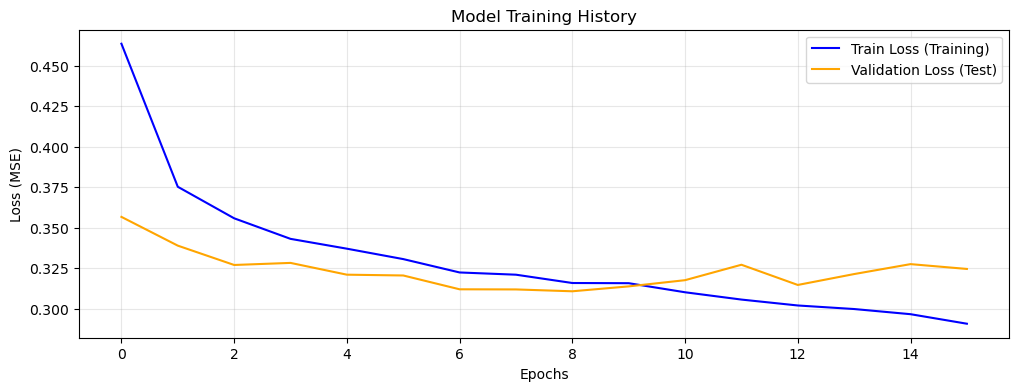

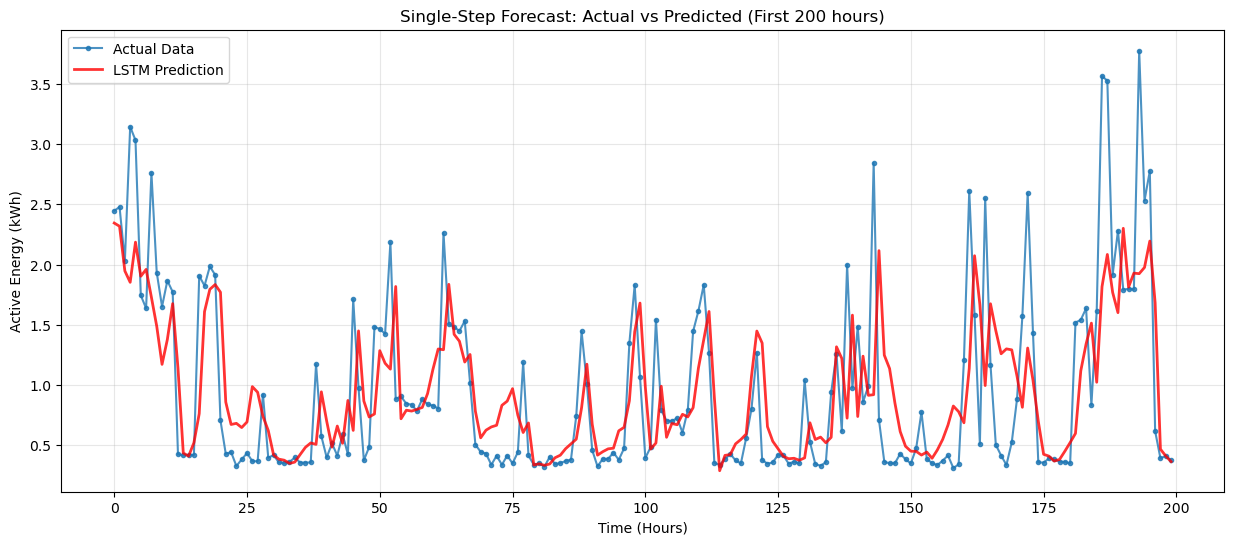

In [ ]:
# 1. Generate Data for Single Step
X_all, y_all = create_sequences(df_scaled, look_back=LOOK_BACK, horizon=1)

X_train = X_all[:idx_train]
y_train = y_all[:idx_train]
X_val = X_all[idx_train:idx_val]
y_val = y_all[idx_train:idx_val]
X_test = X_all[idx_val:]
y_test = y_all[idx_val:]

print(f"Single-Step Input Shape: {X_train.shape}")

# 2. Define Model
model_ss = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

model_ss.compile(optimizer='adam', loss='mse', metrics=['mae'])

# 3. Train
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

history_ss = model_ss.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64, # Increased batch size for speed
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1
)

# 4. Evaluation
pred_ss = scaler_target.inverse_transform(model_ss.predict(X_test))
y_test_orig = scaler_target.inverse_transform(y_test)

mae_ss = mean_absolute_error(y_test_orig, pred_ss)
print(f"Single-Step MAE: {mae_ss:.3f} kWh")

# --- 1. Learning graphic (Loss) ---
plt.figure(figsize=(12, 4))
plt.plot(history_ss.history['loss'], label='Train Loss (Training)', color='blue')
plt.plot(history_ss.history['val_loss'], label='Validation Loss (Test)', color='orange')
plt.title('Model Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# --- 2. Forecast visual
plt.figure(figsize=(15, 6))


subset_n = 200 

plt.plot(y_test_orig[:subset_n], marker='.', label='Actual Data', color='tab:blue', alpha=0.8)
plt.plot(pred_ss[:subset_n], label='LSTM Prediction', color='red', linewidth=2, alpha=0.8)

plt.title(f"Single-Step Forecast: Actual vs Predicted (First {subset_n} hours)")
plt.xlabel("Time (Hours)")
plt.ylabel("Active Energy (kWh)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Conclusion: Single-Step LSTM Performance

The Single-Step LSTM model (predicting $t+1$) demonstrates strong predictive capability and effectively captures the short-term dynamics of household energy consumption.

### Quantitative Performance
- **Global MAE:** The model achieved a Mean Absolute Error of 0.314 kWh.  
- **Improvement:** Compared to the Naive Baseline (~0.563 kWh), this represents a ~44% reduction in error, confirming that the Deep Learning approach provides significant value over simple persistence models.

### Training Stability
- The loss curves show healthy convergence.  
- The validation loss reached its minimum around Epoch 9.  
- The Early Stopping mechanism halted training at Epoch 16 and restored the optimal weights, preventing overfitting while maximizing generalization on unseen data.

### Visual Analysis and Forecast Interpretation
- **Sequential Prediction ($t+1$):** The forecast plot displays 200 individual 1-hour predictions stitched together, not a single 200-hour forecast. This demonstrates the model's **high reactivity**: at each time step, it successfully updates its state based on the latest data to correct the trajectory for the next hour.  
- **Trend & Seasonality:** The model (red line) tightly follows the timing of actual consumption (blue line), correctly capturing daily cycles (morning/evening peaks) and weekend patterns thanks to the 168-hour memory.  
- **Limitation (Extreme Values):** While the timing of spikes is accurate, the model tends to underestimate the amplitude of extreme peaks. This is a known characteristic of models optimized with Mean Squared Error (MSE), which tends to smooth out high-variance outliers to minimize global average error.

It is important to note that the long forecast horizon displayed in the plot is **not** a single multi-hour prediction. Instead, it is a **reconstructed sequence of single-step forecasts**, where each prediction is made one hour ahead using the most recent 168 hours of observed (true) data. This setup evaluates the model’s ability to react accurately on an hour-by-hour basis, not its capacity to plan far into the future.

### Single-Step LSTM Conclusion
The Single-Step model is validated as a **robust short-term forecasting tool**. It demonstrates strong accuracy, stable training behavior, and excellent reactivity to immediate demand changes. Its limitation lies in predicting extreme values accurately, which are slightly smoothed due to MSE optimization.  

We will now move on to the more challenging **Day-Ahead (Multi-Step)** forecasting task, where true multi-horizon prediction capabilities will be assessed.


### 9. Multi-step LSTM Model

This is the model to predict the next 24 hours.

**Improvements:**
1.  **Stacked Architecture:** We use **two LSTM layers**. The first one (128 units) passes sequences to the second one (64 units). This allows the model to learn more complex temporal abstractions.
2.  **Learning Rate Scheduler:** We use `ReduceLROnPlateau`. If the error stagnates, we automatically lower the learning rate to fine-tune the model.
3.  **Extended Training:** We allow up to 100 epochs with Early Stopping.

Generating sequences for 24h Horizon...
Multi-Step Input Shape: (24044, 168, 16)
Epoch 1/100
376/376 ━━━━━━━━━━━━━━━━━━━━ 66s 169ms/step - loss: 0.5976 - mae: 0.5976 - val_loss: 0.5491 - val_mae: 0.5491 - learning_rate: 0.0010
Epoch 2/100
376/376 ━━━━━━━━━━━━━━━━━━━━ 62s 165ms/step - loss: 0.5210 - mae: 0.5210 - val_loss: 0.5427 - val_mae: 0.5427 - learning_rate: 0.0010
Epoch 3/100
376/376 ━━━━━━━━━━━━━━━━━━━━ 63s 167ms/step - loss: 0.4854 - mae: 0.4854 - val_loss: 0.5511 - val_mae: 0.5511 - learning_rate: 0.0010
Epoch 4/100
376/376 ━━━━━━━━━━━━━━━━━━━━ 71s 188ms/step - loss: 0.4616 - mae: 0.4616 - val_loss: 0.5634 - val_mae: 0.5634 - learning_rate: 0.0010
Epoch 5/100
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.4459 - mae: 0.4459
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
376/376 ━━━━━━━━━━━━━━━━━━━━ 67s 177ms/step - loss: 0.4420 - mae: 0.4420 - val_loss: 0.5722 - val_mae: 0.5722 - learning_rate: 0.0010
Epoch 6/100
376/376 ━━━━━━━━━━━━━━━━━━━━ 

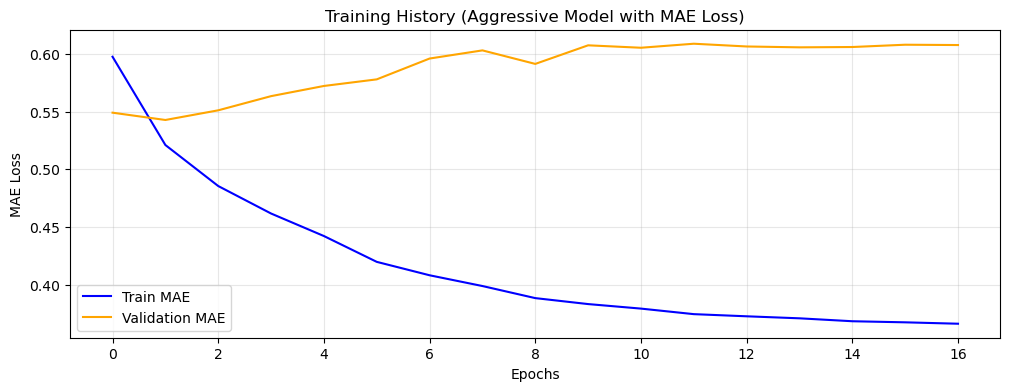

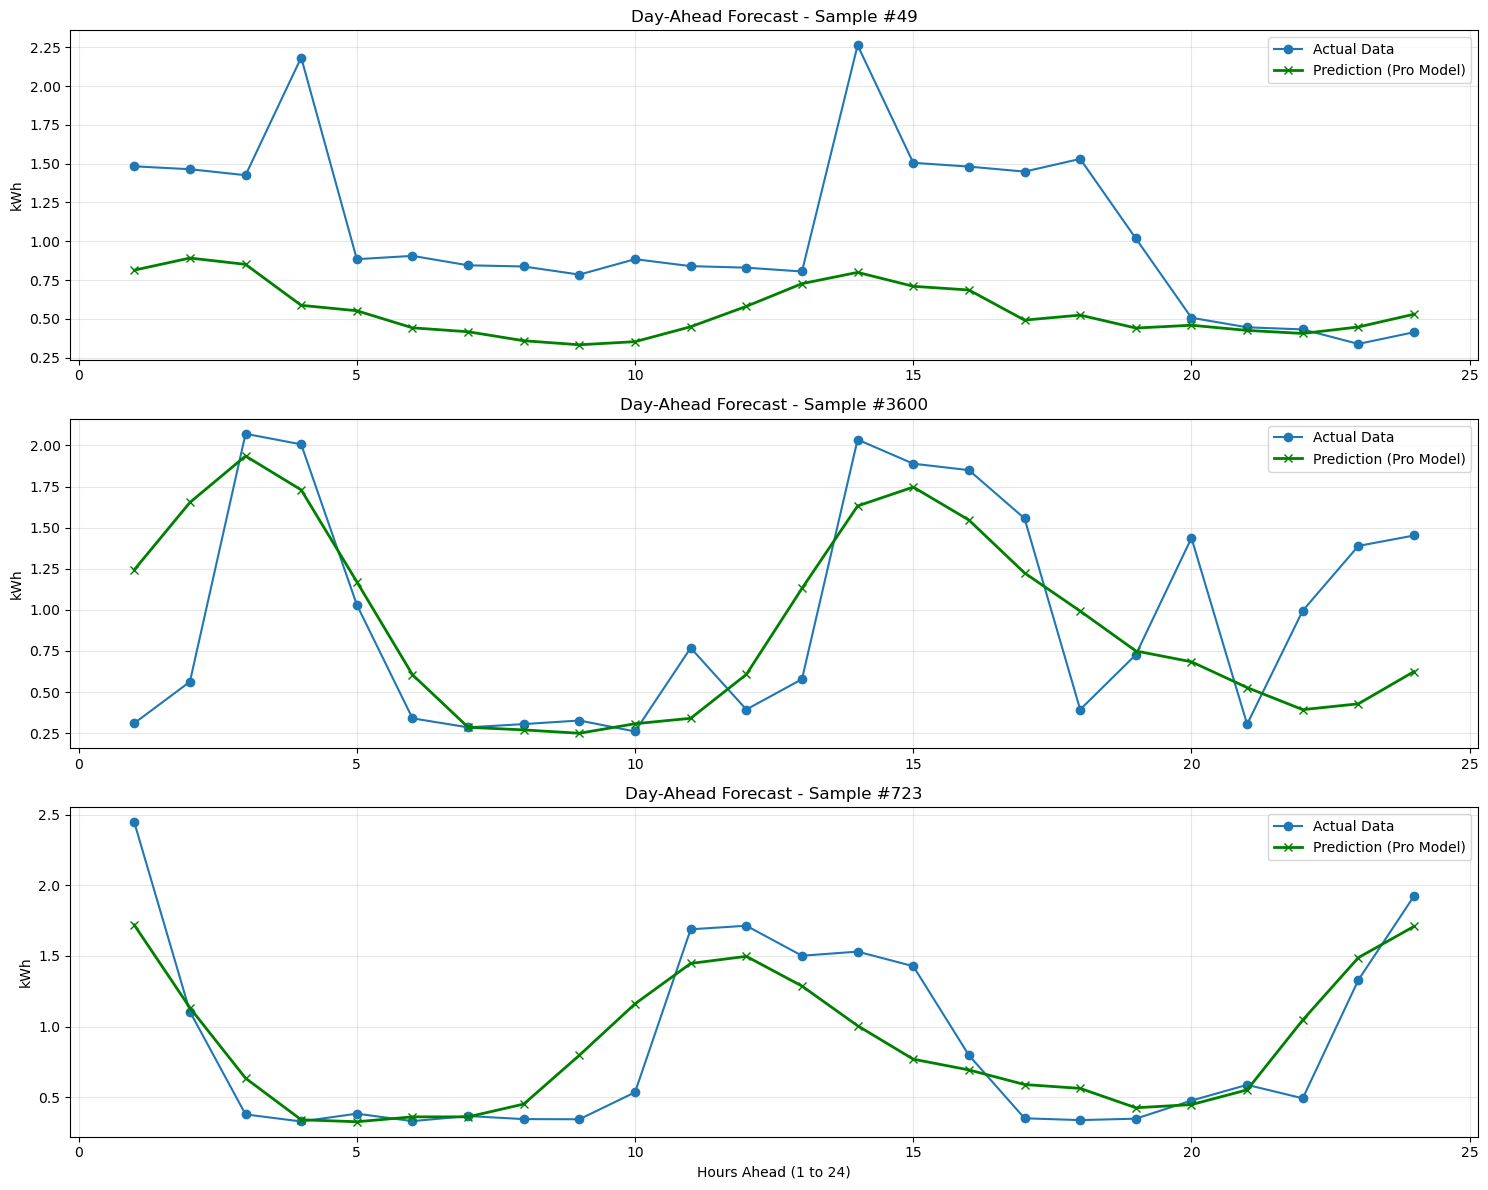

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import random

# 1. Generate Data for Multi-Step (24h)
print(f"Generating sequences for {HORIZON_MS}h Horizon...")

# On recrée les séquences pour être sûr
X_all_ms, y_all_ms = create_sequences(df_scaled, look_back=LOOK_BACK, horizon=HORIZON_MS)

# Re-calc indices
idx_train_ms = df.index.get_loc(train_end_date) - LOOK_BACK + 1
idx_val_ms = df.index.get_loc(val_end_date) - LOOK_BACK + 1

X_train_ms = X_all_ms[:idx_train_ms]
y_train_ms = y_all_ms[:idx_train_ms]
X_val_ms = X_all_ms[idx_train_ms:idx_val_ms]
y_val_ms = y_all_ms[idx_train_ms:idx_val_ms]
X_test_ms = X_all_ms[idx_val_ms:]
y_test_ms = y_all_ms[idx_val_ms:]

print(f"Multi-Step Input Shape: {X_train_ms.shape}")

# 2. Define Multi-Step LSTM Model 
model_pro = Sequential([
    Input(shape=(X_train_ms.shape[1], X_train_ms.shape[2])),
    
    # Layer 1 : 128 
    LSTM(128, return_sequences=True), 
    Dropout(0.2), 
    
    # Layer 2 : 64 
    LSTM(64, return_sequences=False),
    Dropout(0.2), 
    
    # Layer 
    Dense(64, activation='relu'),
    
    # Output: 24h vector
    Dense(HORIZON_MS) 
])


model_pro.compile(optimizer='adam', loss='mae', metrics=['mae'])

# 3. Callbacks

early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5, verbose=1)

# 4. Train
history_pro = model_pro.fit(
    X_train_ms, y_train_ms,
    epochs=100,
    batch_size=64,
    validation_data=(X_val_ms, y_val_ms),
    callbacks=[early_stop, lr_scheduler],
    verbose=1
)

# 5. Evaluation & Plot
pred_pro = scaler_target.inverse_transform(model_pro.predict(X_test_ms))
y_test_orig_ms = scaler_target.inverse_transform(y_test_ms)

mae_pro = mean_absolute_error(y_test_orig_ms, pred_pro)
print(f"\n=== Stacked LSTM Results (Week Memory - Aggressive V3) ===")
print(f"Global MAE:  {mae_pro:.3f} kWh")

# Visualization 
# --- 1. Learning graphic (Loss) ---
plt.figure(figsize=(12, 4))
plt.plot(history_pro.history['loss'], label='Train MAE', color='blue')
plt.plot(history_pro.history['val_loss'], label='Validation MAE', color='orange')
plt.title('Training History (Aggressive Model with MAE Loss)')
plt.xlabel('Epochs')
plt.ylabel('MAE Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# --- 2. Visualization (Day-Ahead) ---
#   3 take 3 random days to see if peaks are captured
random_indices = random.sample(range(len(y_test_orig_ms)), 3)

plt.figure(figsize=(15, 12))

for i, idx in enumerate(random_indices):
    plt.subplot(3, 1, i+1)
    # Réalité
    plt.plot(range(1, 25), y_test_orig_ms[idx], marker='o', label='Actual Data', color='tab:blue')
    # Prédiction
    plt.plot(range(1, 25), pred_pro[idx], marker='x', label='Prediction (Pro Model)', color='green', linewidth=2)
    
    plt.title(f"Day-Ahead Forecast - Sample #{idx}")
    plt.ylabel("kWh")
    if i == 2:
        plt.xlabel("Hours Ahead (1 to 24)")
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## General Conclusion: Energy Consumption Forecasting

### Project Objective & Context
The primary objective of this project was to develop a Deep Learning system capable of predicting the electricity consumption of a single household. In the context of Smart Home energy management, the goal was twofold:  
- **Monitoring:** Precise short-term prediction ($t+1$) to detect anomalies.  
- **Planning:** Reliable day-ahead prediction ($t+24$) to optimize appliance scheduling and energy trading.

### Methodology Implemented
To address the stochastic nature of individual household consumption, we implemented a Stacked LSTM (Long Short-Term Memory) architecture.  
- **Feature Engineering:** We utilized a 168-hour (1 week) sliding window input to capture critical daily cycles and weekly seasonality.  
- **Incremental Approach:** We first validated the architecture on a Single-Step task (achieving a high precision of 0.314 kWh MAE) before tackling the more complex Multi-Step (Day-Ahead) challenge.  
- **Training Control:** In both setups, an Early Stopping mechanism was applied, allowing the training process to automatically stop at the optimal number of epochs and restore the best-performing weights, ensuring good generalization without overfitting.

### Key Optimization Strategy
The decisive factor in achieving strong performance was the strategic switch of the **loss function from MSE to MAE**.  
- **The Challenge:** Initial models trained with Mean Squared Error (MSE) suffered from *regression to the mean*, leading to overly smooth forecasts that failed to capture consumption peaks.  
- **The Solution:** By switching to Mean Absolute Error (MAE) and maintaining a high network capacity (128 units), the model became more *aggressive*, enabling it to better capture the amplitude and timing of demand peaks without introducing gradient instability.

### Operational Impact & Final Verdict
The project objectives have been met.  

- **For Monitoring:** The Single-Step model provides high-precision real-time tracking by predicting only the next hour ($t+1$). Because it is continuously updated with the latest true observations, it can effectively *adapt hour by hour* to sudden changes in consumption, which explains its high short-term accuracy.  

- **For Planning:** The Multi-Step (Day-Ahead) model predicts **multiple future hours at once** (e.g., $t+1$ to $t+24$) without access to intermediate ground-truth values. This allows it to anticipate the overall shape of the next day’s load curve, including peak periods, rather than merely reacting hour by hour.  

It is important to note that the **lower precision of the Multi-Step model is expected**. Predicting further into the future inherently introduces more uncertainty, as the model cannot rely on intermediate true observations and must contend with unobserved external factors (e.g., behavioral changes or weather variability). Despite this, the Multi-Step model remains highly valuable, as it captures the **structural dynamics and daily patterns** required for planning tasks.  

As a result, while the Single-Step model excels at short-term responsiveness, the Multi-Step model provides a broader view of the future, making it more appropriate for **operational planning and decision-making**, such as anticipating the evening peak to delay heavy appliance usage. These results validate the effectiveness of LSTM-based models for residential energy optimization.
